In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, Add, Dense, ZeroPadding2D, Activation, BatchNormalization, \
    Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
from classification_models.resnet import ResNet18

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

# list of columns to include from qcd/dihiggs data:
#
# hh_mass h1_mass h2_mass hh_pt h1_pt h2_pt deltaR(h1, h2) deltaR(h1 jets) deltaR(h2 jets)
#  0        1       2       3     4     5     6              7               8
# deltaPhi(h1, h2) deltaPhi(h1 jets) deltaPhi(h2 jets) met met_phi scalarHT nJets nBTags isMatchable
#     9                 10              11             12    13       14     15    16       17
# jet1_pt jet2_pt jet3_pt jet4_pt jet1_eta jet2_eta jet3_eta jet4_eta jet1_phi jet2_phi jet3_phi jet4_phi
#  18      19       20       21      22       23       24       25        26      27       28       29
# jet1_mass jet2_mass jet3_mass jet4_mass jet1_px jet2_px jet3_px jet4_px jet1_py jet2_py jet3_py jet4_py 
#     30        31        32        33        34      35      36      37      38      39      40      41
# jet1_pz jet2_pz jet3_pz jet4_pz jet1_energy jet2_energy jet3_energy jet4_energy 
#     42      43      44      45      46          47          48          49
# jet1_btag jet2_btag jet3_btag jet4_btag (fake_column) LABEL
#     50        51        52        53        (54)       55 (54 if no fake column)

Using TensorFlow backend.


ModuleNotFoundError: No module named 'classification_models.resnet'

In [2]:
def plot_training_history(hist):
    '''
    hist: keras model history from training - model.fit()
    '''
    
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['loss'])
    plt.title('Model accuracy and loss')
    plt.ylabel('Accuracy/Loss')
    plt.xlabel('Epoch')
    plt.legend(['Accuracy', 'Loss'], loc='upper left')
    plt.show()
    

def get_real_data(n_events):
    '''
    read from csv files
    returns n_events of each class
    '''
    qcd_data_original = np.genfromtxt("qcd_outputDataForLearning.csv", skip_header=1, delimiter=",")
    hh_data_original  = np.genfromtxt("dihiggs_outputDataForLearning.csv", skip_header=1, delimiter=",")
    
    # # getting rid of "isMatchable" columns and "Btag Jet1234" columns
    # qcd_data_original = np.delete(qcd_data_original, [17, 53, 52, 51, 50], 1)
    # hh_data_original  = np.delete(hh_data_original,  [17, 53, 52, 51, 50], 1)
    
    qcd_data_original = qcd_data_original[:n_events,:]
    hh_data_original  =  hh_data_original[:n_events,:]
    
    
    return hh_data_original, qcd_data_original

def generate_uniform_fake_cols(hh_rows, qcd_rows, n_cols, is_separable):
    '''
    create 2 np arrays with hh_rows x n_cols, and qcd_rows, n_cols
    isseparable is a boolean - if True, hh will has all positive values [0,1]
    qcd will have all negative values [-1,0]
    else they will both be positive values [0,1]
    '''
    hh_fake = np.random.rand(hh_rows, n_cols)
    qcd_fake = np.random.rand(qcd_rows, n_cols)

    hh_fake = np.abs(hh_fake)
    qcd_fake = np.abs(qcd_fake)

    if is_separable:
        hh_fake = hh_fake * (1/np.max(hh_fake))
        qcd_fake = -qcd_fake * (1/np.max(qcd_fake))
    else:
        hh_fake = hh_fake * (1/np.max(hh_fake))
        qcd_fake = qcd_fake * (1/np.max(qcd_fake))
    
    return hh_fake, qcd_fake

def generate_gaussian_fake_cols(hh_rows, qcd_rows, n_cols, mu_hh, std_hh, mu_qcd, std_qcd):
    '''
    create 2 np arrays with hh_rows x n_cols, and qcd_rows, n_cols
    hh data randomly distributed with mu_hh and std_hh
    qcd data randomly distributed with mu_qcd and std_qcd
    '''
    hh_fake = np.random.normal(mu_hh,    std_hh, (hh_rows, n_cols))
    qcd_fake = np.random.normal(mu_qcd, std_qcd, (qcd_rows, n_cols))
    
    return hh_fake, qcd_fake
    
    
def add_labels_and_data(hh_data, qcd_data, n_rows, n_columns, iteration=None):
    '''
    create label column for qcd (0) and hh (1)
    select certain columns of interest - iteration is a list of column indexes
    returns one np array of the concatenation of the 2 datasets. Add m columns
    of zeros where m = (n_rows*n_cols)-n_features. 
    When iteration is true, assumes iteration includes labels.
    '''
    n_features = len(iteration)-1
    m = (n_rows*n_columns)-n_features
#     print("m =", m)
    
    # generate labels for hh and qcd
    hh_labels= np.ones((len(hh_data),1))
    hh_data_original = np.append(hh_data, hh_labels, axis=1)

    qcd_labels= np.zeros((len(qcd_data),1))
    qcd_data_original = np.append(qcd_data, qcd_labels, axis=1)
    
    # add all data together
    all_data_original = np.append(hh_data_original, qcd_data_original, axis=0)
    
    if iteration is not None:
        all_data = all_data_original[:,iteration]
#         print("m in loop", m)
        print(np.shape(all_data))
        for i in range(m):
            all_data = np.insert(all_data, -1, np.zeros([1,1]), axis=1)
            print(np.shape(all_data))
    else:
        all_data = all_data_original
    
    return all_data
    
    


In [4]:
# image size
image_rows = 3
image_cols = 3
channels   = 1

hh, qcd = get_real_data(1700)
all_data = add_labels_and_data(hh, qcd, image_rows, image_cols, iteration=[0,1,2,6,7,8,9,10,11,54])

# # shuffle data and separate data and label
# for i in range(4):
#     np.random.shuffle(all_data)

y    = all_data[:,-1]
X    = all_data[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)


# one hot encoding for labels
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)


# change input dimensions so it has 4 dimension tensor instead of 2
X_train     = np.reshape(X_train, (X_train.shape[0],image_rows,image_cols,channels))
X_test      = np.reshape(X_test,   (X_test.shape[0],image_rows,image_cols,channels))


# X dimensions: (num_samples, img_size, img_size, channels) 
# Y dimensions: (num_samples, num_classes)
print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = "     + str(X_test.shape[0]))
print("X_train shape: "                + str(X_train.shape))
print("Y_train shape: "                + str(y_train.shape))
print("X_test shape:  "                 + str(X_test.shape))
print("Y_test shape:  "                 + str(y_test.shape))


# create model
model = ResNet18(include_top=True, weights=None, input_shape=(image_rows,image_cols,channels), classes=2)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# fit model to data, evaluate it against testing data
history = model.fit(X_train, y_train, epochs=3, batch_size=32)
preds   = model.evaluate(X_test, y_test)
print("Test Loss     = ", preds[0])
print("Test Accuracy = ", preds[1])




number of training examples = 2550
number of test examples = 850
X_train shape: (2550, 3, 3, 1)
Y_train shape: (2550, 2)
X_test shape:  (850, 3, 3, 1)
Y_test shape:  (850, 2)
Epoch 1/3
2550/2550 [==============================] - 81s 32ms/step - loss: 0.7288 - acc: 0.6627
Epoch 2/3
2550/2550 [==============================] - 78s 30ms/step - loss: 0.6131 - acc: 0.6859
Epoch 3/3
850/850 [==============================] - 1s 1ms/step
Test Loss     =  0.6201022055569817
Test Accuracy =  0.6847058822126949


In [15]:
actual_preds = model.predict(X_test)


In [18]:
# pred_classes = []

# for pred in actual_preds:
#     if pred[0] > pred[1]:
#         pred_classes.append(0)
#     elif pred[0] < pred[1]:
#         pred_classes.append(1)
#     else:
#         print("problem")
#         continue

# results = []
# actual_qcd = 0
# actual_hh = 0

# preds_missed_qcd = []
# preds_missed_hh = []

# for j in range(len(y_test)):
#     if np.array_equal(y_test[j], [0, 1]):
#         actual_hh += 1
#         if pred_classes[j] != 1:
#             results.append("missed_dihiggs")
#             preds_missed_hh.append(actual_preds[j])
#     else:
#         actual_qcd += 1
#         if pred_classes[j] != 0:
#             results.append("missed_qcd")
#             preds_missed_qcd.append(actual_preds[j])
    
# missed_qcd = 0
# missed_hh = 0

# preds_missed_qcd = np.asarray(preds_missed_qcd)
# preds_missed_hh = np.asarray(preds_missed_hh)

# for thing in results:
#     if thing == "missed_qcd":
#         missed_qcd += 1
#     if thing == "missed_dihiggs":
#         missed_hh += 1

# print(missed_qcd, actual_qcd, 1 - missed_qcd/actual_qcd)
# print(missed_hh, actual_hh, 1 - missed_hh/actual_hh)
# print(len(y_test))

299 435 0.31264367816091954
84 1142 0.9264448336252189
1577


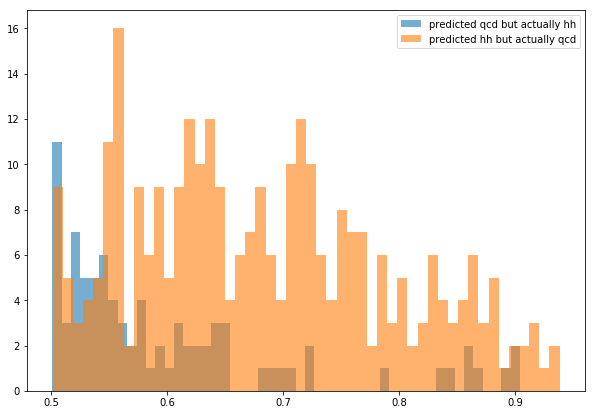

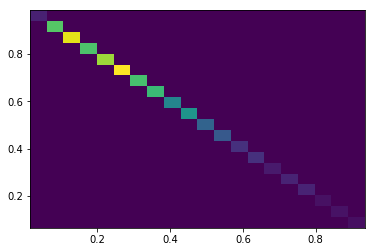

In [32]:
# t = 0.6

# plt.figure(1, figsize=(10,7))
# # plt.hist(actual_preds[:,0], label='qcd', alpha=t, bins =50)
# # plt.hist(actual_preds[:,1], label='dihiggs', alpha=t, bins=50)
# plt.hist(preds_missed_hh[:,0], label='predicted qcd but actually hh', alpha=t, bins=50)
# plt.hist(preds_missed_qcd[:,1], label='predicted hh but actually qcd', alpha=t, bins=50)
# plt.legend(loc='upper right')

# plt.figure(2)
# plt.hist2d(actual_preds[:,0], actual_preds[:,1], 20)

# plt.show()


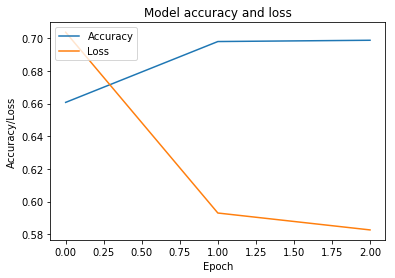

In [35]:
# plot_training_history(history)

In [39]:
# print(model.summary())

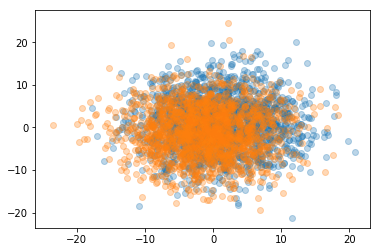

In [67]:
hh_fake, qcd_fake = generate_gaussian_fake_cols(1700, 1700, 9, 1, 6, -1, 6)
plt.scatter(hh_fake[:,0], hh_fake[:,1], alpha=0.3)
plt.scatter(qcd_fake[:,0], qcd_fake[:,1], alpha=0.3)
plt.show()

In [ ]:
# from skimage import data
# from scipy import ndimage

# for i in range(len(X_test)):
#     x_image = X_test[i]
#     x_image = np.reshape(x_image, (3,2))
#     if np.array_equal(y_test[i], [0, 1]):
#         plt.imsave('images/test/hh'+str(i)+'.png',x_image)
#     else:
#         plt.imsave('images/test/qcd'+str(i)+'.png',x_image)
        
# for i in range(len(X_train)):
#     x_image = X_train[i]
#     x_image = np.reshape(x_image, (3,2))
#     if np.array_equal(y_train[i], [0, 1]):
#         plt.imsave('images/train/hh'+str(i)+'.png',x_image)
#     else:
#         plt.imsave('images/train/qcd'+str(i)+'.png',x_image)
        
# from keras.preprocessing.image import ImageDataGenerator

# batch_size = 32

# # this is the augmentation configuration we will use for training
# train_datagen = ImageDataGenerator(
#         shear_range=0.2,
#         zoom_range=0.2)

# # this is the augmentation configuration we will use for testing:
# # only rescaling
# test_datagen = ImageDataGenerator(shear_range=0.2,zoom_range=0.2)

# # this is a generator that will read pictures found in
# # subfolers of 'data/train', and indefinitely generate
# # batches of augmented image data
# train_generator = train_datagen.flow_from_directory(
#         'images/train',  # this is the target directory
#         target_size=(3, 2),  # all images will be resized to 150x150
#         batch_size=batch_size,
#         class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# # this is a similar generator, for validation data
# validation_generator = test_datagen.flow_from_directory(
#         'images/test/',
#         target_size=(3, 2),
#         batch_size=batch_size,
#         class_mode='categorical')

# model = ResNet18(include_top=True, weights=None, input_shape=(3, 2, 3), classes=2)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.fit_generator(
#         train_generator,
#         steps_per_epoch=2550//32,
#         epochs=32,
#         validation_data=validation_generator,
#         validation_steps=850//32)